# Exercise M09: Graph Neural Networks

## Image Processing

Let's perform the Fourier transform on an image.  
For an image $X$ with size $H \times W$, the Fourier transform of $X$ is:

$$
\begin{aligned}
\mathcal{F}(X)[h, w] &= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] \cdot e^{-2\pi i \frac{hk}{H}} \cdot e^{-2\pi i \frac{w\ell}{W}} \\
&= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}
\end{aligned}
$$

The exponential term $e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}$ represents a 2D wave with frequency $(h, w)$, which looks like the following: 


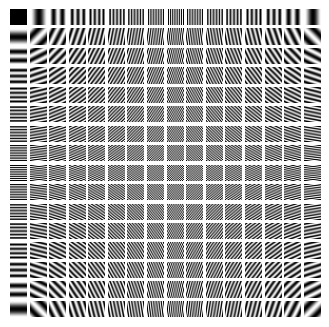

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def basis_function(img_size=256, u=0, v=0):
  '''
  img_size : square size of image f(x,y)
  u,v : spatial space indice
  '''
  N = img_size
  x = np.linspace(0, N-1, N)
  y = np.linspace(0, N-1, N)
  x_, y_ = np.meshgrid(x, y)
  bf = np.exp(-1j*2*np.pi*(u*x_/N+v*y_/N))
  if u == 0 and v == 0:
    bf = np.round(bf)
  real = np.real(bf) # The cosine part
  imag = np.imag(bf) # The sine part
  return real, imag

size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(size):
  for row in range(size):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
_, axs = plt.subplots(size, size, figsize=(4, 4))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')


**Note 🤔**: It is common to reorder the basis functions such that the lowest frequency components are at the center, which looks like this:


Text(0.5, 0.98, 'Real Part of Basis Functions')

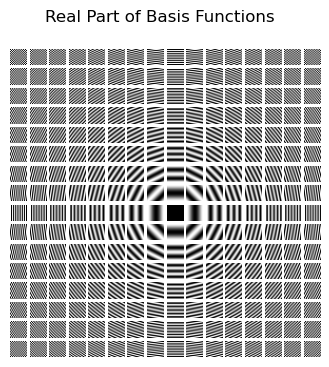

In [9]:
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(-size//2, size//2):
  for row in range(-size//2, size//2):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
fig, axs = plt.subplots(size, size, figsize=(4, 4))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Real Part of Basis Functions')



Now, let's perform the Fourier transform on an image.


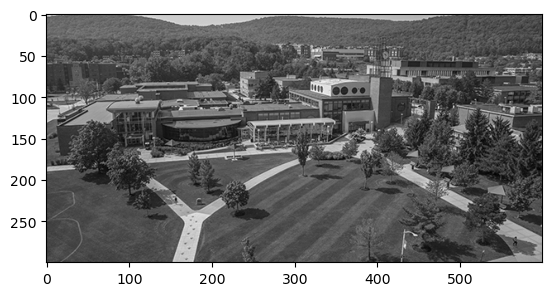

In [2]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Read image from URL
def read_jpeg_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Convert to RGB mode if needed (in case it's RGBA)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def image_to_numpy(img):
    return np.array(img)

def to_gray_scale(img_np):
    return np.mean(img_np, axis=2)

# URL of the image. You can change this to any image you want.
url = "https://www.binghamton.edu/news/images/uploads/features/20180815_peacequad02_jwc.jpg"

img = read_jpeg_from_url(url)
img_np = image_to_numpy(img)
img_gray = to_gray_scale(img_np)

plt.imshow(img_gray, cmap='gray')

Take the Fourier transform of the image.

In [3]:
ft_img_gray = np.fft.fft2(img_gray)

This decomposes the image into a sum of basis waves. Let's see the weights of the basis waves.

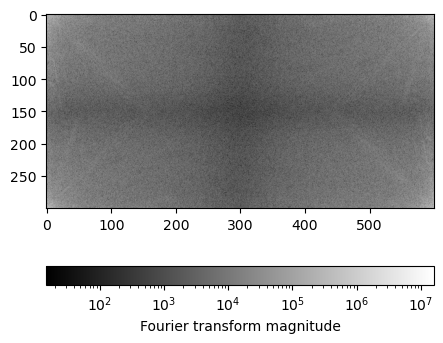

In [5]:
import matplotlib

weight = np.abs(ft_img_gray)

# real part
fig1, ax1 = plt.subplots(figsize=(5, 5))

ax1.imshow(weight, cmap='gray', norm=matplotlib.colors.LogNorm(), aspect='equal')
cbar = fig1.colorbar(ax1.images[0], ax=ax1, orientation='horizontal')
cbar.set_label('Fourier transform magnitude')

The brighter the pixel is, the more dominant the corresponding basis wave is in the image. We observed that there are some high frequency components, which correspond to the edges of the image.

Now, let's see the convolution of the image with a Prewitt operator.

In [11]:
K = np.array(
    [
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1],
    ]
)  # Prewitt operator

This operator is used to detect the horizontal edges of the image. 
Let's compute the Fourier transform of the Prewitt operator.

In [12]:
K_padd = np.zeros((img_gray.shape[0], img_gray.shape[1]))
K_padd[:K.shape[0], :K.shape[1]] = K

# convolution
FK = np.fft.fft2(K_padd)

**Note 🤔**: We have padded the operator to the same size as the image, which is the required to perform the convolution. Now, let's see the weights of the basis waves.


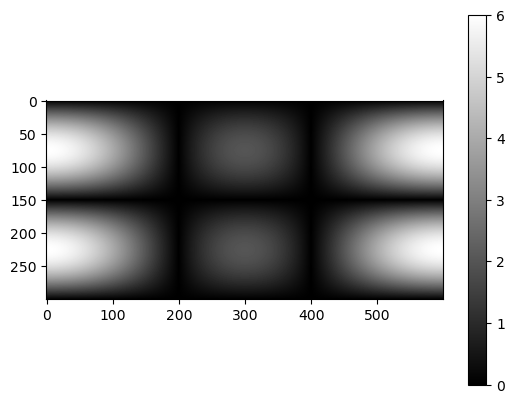

In [14]:
plt.imshow(np.abs(FK), cmap='gray')
cbar = plt.colorbar()

Observe that the low frequency components are suppressed, and the high frequency components are enhanced. This is because the Prewitt operator is a high-pass filter that only allows high-frequency components to pass through.


We now perform the convolution of the image with the Prewitt operator.

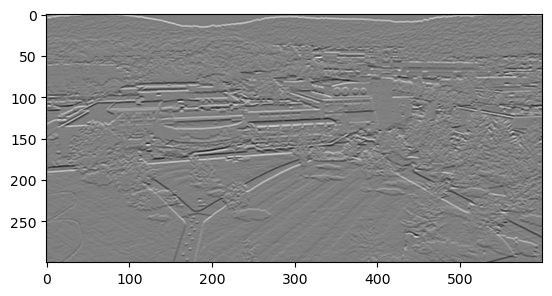

In [15]:
FX = np.fft.fft2(img_gray)
conv_img_gray = np.real(np.fft.ifft2(FX * FK))
plt.imshow(conv_img_gray, cmap='gray')

### Exercise 1 🏋️:

Design your own kernel to:
1. Detect the vertical edges of the image.
2. Smooth the image.


**1. Kernel to detect the vertical edges of the image.**

**2. Kernel to smooth the image.**

## Spectral Graph Convolutional Networks

We can think of a convolution of an image from the perspective of networks.
In the convolution of an image, a pixel is convolved with its *neighbors*. We can regard each pixel as a node, and each node is connected to its neighboring nodes (pixels) that are involved in the convolution.

![](https://av-eks-lekhak.s3.amazonaws.com/media/__sized__/article_images/conv_graph-thumbnail_webp-600x300.webp)

Suppose that each node has a variable $x_i \in \mathbb{R}$, just like each pixel has a value in a grey image. Consider a network of $N$ such nodes. 

In this example, we use the karate club network and set $x$ by a random gaussian variable.

In [20]:
import igraph as ig
import numpy as np
from scipy import sparse
import matplotlib as mpl

G = ig.Graph.Famous("Zachary")
A = G.get_adjacency_sparse()

x = np.random.randn(G.vcount())



We define the *total variation* of ${\mathbf x}$ as the sum of the squared differences between connected nodes:

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 = {\bf x}^\top {\bf L} {\bf x},
$$

where ${\bf L}$ is the Laplacian matrix of the graph given by

$$
L_{ij} = \begin{cases}
-1 & \text{if } i \text{ and } j \text{ are connected} \\
k_i & \text{if } i = j \\
0 & \text{otherwise}
\end{cases}.
$$

and ${\bf x} = [x_1,x_2,\ldots, x_N]^\top$ is a column vector of feature variables.

In [80]:
# Compute the total variation of x by definition
J = 0
for i in range(G.vcount()):
  for j in range(G.vcount()):
    if A[i,j] != 0:
      J += (x[i] - x[j])**2
J = J / 2

# Compute the total variation of x by using the Laplacian matrix
deg = A.sum(axis = 1).A1
L = sparse.diags(deg) - A
J_by_laplacian = x.T @ L @ x

print(f"J: {J}, J_by_laplacian: {J_by_laplacian}")

J: 188.37184304622707, J_by_laplacian: 188.37184304622718


We decompose the total variation into high-frequency and low-frequency components by using the eigenvectors ${\bf u}_i$ and the eigenvalues $\lambda_i$ of the Laplacian matrix:

$$
J = \sum_{i=1}^N \lambda_i  {\bf x}^\top {\mathbf u}_i {\mathbf u}_i^\top {\bf x} = \sum_{i=1}^N \lambda_i  ||{\bf x}^\top {\mathbf u}_i||^2.
$$

The term $({\bf x}^\top {\mathbf u}_i)$ is a dot-product between the feature vector ${\bf x}$ and the eigenvector ${\mathbf u}_i$, measuring how much ${\bf x}$ aligns with ${\mathbf u}_i$, similar to Fourier coefficients with sinusoids. Each $||{\bf x}^\top {\mathbf u}_i||^2$ represents the ''strength'' of ${\bf x}$ with respect to ${\mathbf u}_i$, making the total variation $J$ a weighted sum of these strengths.

In [81]:
# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigvals, eigvecs = np.linalg.eigh(L.toarray())

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigvals)
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

strength = []
for i in range(len(eigvals)):
  strength.append(np.sum((x.T @ eigvecs[:,i])**2))

J_by_eig = np.sum(strength * eigvals)
print(f"J: {J}, J_by_eig: {J_by_eig}")

J: 188.37184304622707, J_by_eig: 188.37184304622724


And here is the "frequency" of each component in increasing order of eigenvalues (frequency).

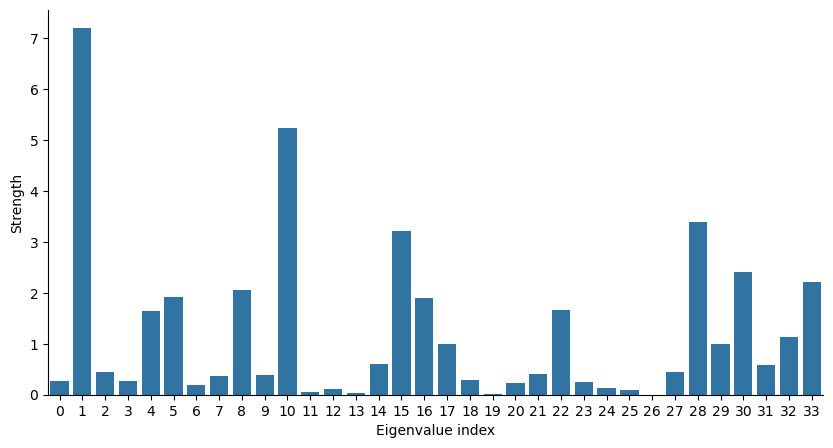

In [82]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength")
sns.despine()
plt.show()

The eigenvalues $\lambda_i$ are then multipled by the strength of the corresponding component, and the total is the total variation $J$.  

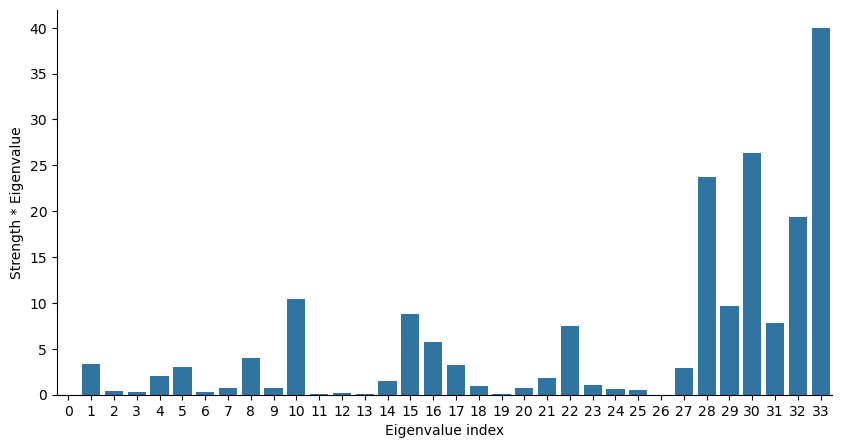

In [83]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength * eigvals)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength * Eigenvalue")
sns.despine()
plt.show()

Now, we can consider "eigenvals" as a filter that controls which frequency components pass through 😉. For example, if we want to keep the low-frequency components, we can set the high-frequency components to zero.

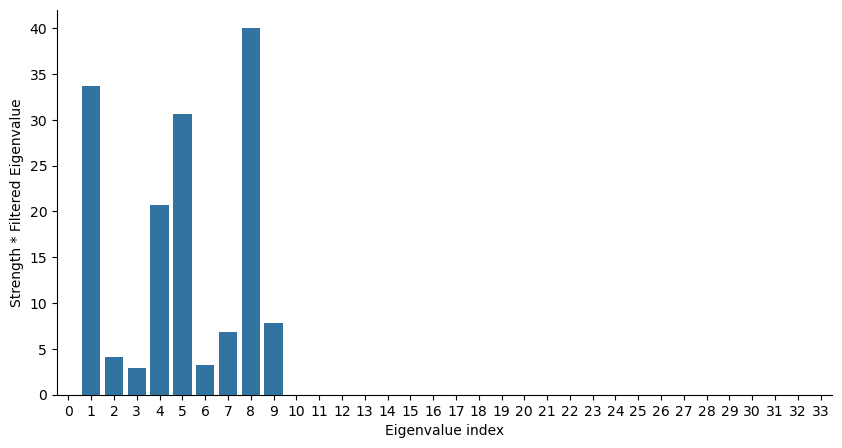

In [84]:
eigvals_filtered = eigvals.copy()
eigvals_filtered[:10] *= 10
eigvals_filtered[10:] = 0

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength * eigvals_filtered)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength * Filtered Eigenvalue")
sns.despine()
plt.show()

Using this filter, we reconstruct the Laplacian matrix.  



In [85]:
L_filtered = eigvecs @ np.diag(eigvals_filtered) @ eigvecs.T

<Axes: title={'center': 'Reconstructed Laplacian from filtered eigenvalues'}>

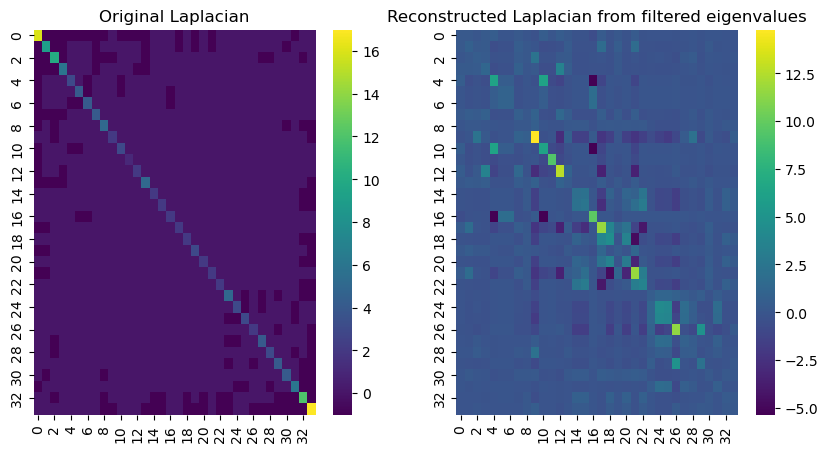

In [86]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Original Laplacian")
axes[1].set_title("Reconstructed Laplacian from filtered eigenvalues")
sns.heatmap(L.toarray(), cmap = 'viridis', ax=axes[0])
sns.heatmap(L_filtered, cmap = 'viridis', ax=axes[1])

We now have a new "convolution" matrix $L_{\text{filtered}}$ with which to generate a new feature vector ${\bf x}'$.

In [87]:
x_prime = L_filtered @ x

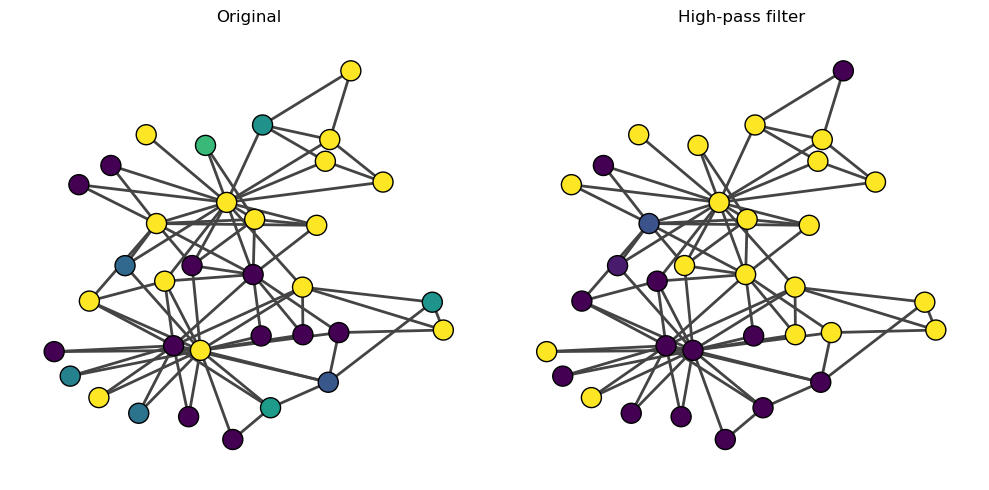

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), )
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x_prime], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("High-pass filter")

fig.tight_layout()

Observe that the values of the nodes are smoothed out, since the high-frequency components are suppressed.

### Exercise 2 🏋️:

Design your own filter to detect the high-frequency components of the graph. And apply the filter to:

1. Random gaussian variables 
2. Eigenvector centrality of the graph.

Then, compare the results with the original ones.

**Construct your own filter**

**Apply the filter to random gaussian variables**

**Apply the filter to eigenvector centrality**

# Graph Convolutional Networks

Let's implement a simple Graph Convolutional Network (GCN) by Kipf & Welling. We will use the karate club network again. To this end, we will use PyTorch. 

In [89]:
import torch

Let's work with multiple features for each node.


In [114]:
X = torch.eye(G.vcount(), 5) # one-hot encoding of the node indices

GCN updates node features by:

$$
x' = \sigma\left( \tilde {\mathbf A} X \Theta\right)
$$

where 
1. $X$ is the feature matrix of the graph,
2. $\sigma$ is an activation function, and 
3. $\Theta$ is a learnable parameter matrix.
4. $\tilde {\mathbf A}$ is the normalized adjacency matrix of the graph (with self-loops).

Let's break down the formula. First, we will compute $\tilde {\mathbf A}$



Next, we will multiply it by feature matrix $X$ and learnable parameter matrix $\Theta$.

In [116]:
A_hat_norm_X = ...

Now, let's prepare the learnable parameters and apply it to the feature matrix. We initialize the learnable parameters by random gaussian variables.




In [120]:
Theta = torch.nn.Parameter(torch.randn(X.shape[1], 5), requires_grad=True)  # The new feature x' has 5 dimensions.

And multiply it by $\tilde {\mathbf A} X$, and apply the activation function $\sigma$. We will use the sigmoid function as the activation function.




In [125]:
A_hat_norm_X_Theta = ...

Now, let's visualize the updated feature matrix. Each row is a new feature vector of a node. 

In [127]:
A_hat_norm_X_Theta

tensor([[0.4874, 0.4985, 0.4863, 0.5207, 0.4766],
        [0.4724, 0.4813, 0.4923, 0.5397, 0.4600],
        [0.4749, 0.4830, 0.4930, 0.5361, 0.4636],
        [0.4606, 0.4732, 0.4890, 0.5565, 0.4430],
        [0.4607, 0.5223, 0.5405, 0.5865, 0.4907],
        [0.4561, 0.4855, 0.5632, 0.5783, 0.4922],
        [0.4685, 0.5178, 0.5324, 0.5694, 0.4926],
        [0.4450, 0.4626, 0.4846, 0.5788, 0.4205],
        [0.4397, 0.4866, 0.5927, 0.5596, 0.4926],
        [0.4523, 0.4974, 0.5810, 0.4881, 0.4983],
        [0.4607, 0.5223, 0.5405, 0.5865, 0.4907],
        [0.3918, 0.4639, 0.6537, 0.6878, 0.4805],
        [0.4379, 0.4604, 0.4017, 0.7428, 0.4216],
        [0.4541, 0.4688, 0.4872, 0.5658, 0.4336],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.4452, 0.4558, 0.5968, 0.5109, 0.4345],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.4588, 0.4668, 0.5730, 0.5082, 0.4508],


Let's visualize the updated feature matrix in 2D space using PCA.

<Axes: >

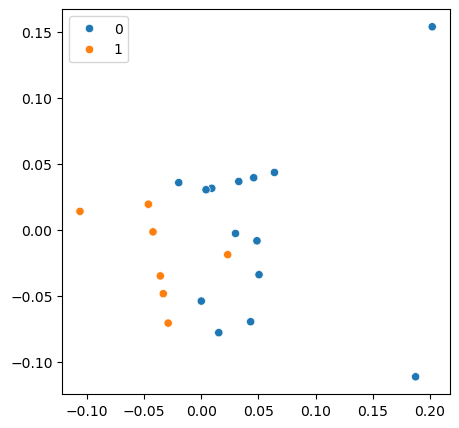

In [130]:
fig, ax = plt.subplots(figsize=(5, 5))

from sklearn.decomposition import PCA
xy = PCA(n_components=2).fit_transform(A_hat_norm_X_Theta.detach().numpy())


# We color the nodes by the membership of the karate club members.
import networkx as nx
Gnx = nx.karate_club_graph()
labels = np.unique([d[1]['club'] for d in Gnx.nodes(data=True)], return_inverse=True)[1]


sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue = labels,  ax=ax)

We observe that the nodes are separated into two clusters, despite the fact that the GCN is **untrained!** 

Now, let's train the GCN to predict the membership of the karate club. Namely, the GCN is given the feature matrix $X$ and the adjacency matrix $A$, and it learns the parameter matrix $\Theta$ to predict the membership of the karate club. We will split the nodes into the training and testing sets, and evaluate the accuracy of the model using the testing set.

In [150]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define the GCN model by putting the above code into a class.
class GCN(torch.nn.Module):
  def __init__(self, in_features, out_features, A):
    super(GCN, self).__init__()
    self.linear = torch.nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)

    A_hat = A + sparse.eye(A.shape[0])
    deg = A_hat.sum(axis=1).A1
    D_hat = sparse.diags(deg)
    D_hat_inv = sparse.diags(1 / deg)
    self.A_hat_norm = D_hat_inv @ A_hat

  def forward(self, x):
    Ax = torch.tensor(self.A_hat_norm @ x, dtype=torch.float32)
    return torch.nn.functional.sigmoid(Ax @ self.linear)

# Initialize the model
model = GCN(in_features=A.shape[0], out_features=2, A = A)

# Initialize the feature matrix
X = torch.eye(A.shape[0])

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize the loss function
criterion = torch.nn.CrossEntropyLoss()

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(np.arange(G.vcount()), test_size=0.2, random_state=42)
labels = torch.tensor(labels)
train_features = X[train_idx]
train_labels = labels[train_idx]
test_features = X[test_idx]
test_labels = labels[test_idx]

# Define the number of training epochs
n_train = 200

# Initialize the progress bar
pbar = tqdm(range(n_train))

# Initialize the loss history
loss_history = []

# Train the model
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output[train_idx], train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        output = model(X)
        _, predicted = torch.max(output, 1)
        accuracy = (predicted[test_idx] == test_labels).float().mean()
        loss_history.append(loss.item())
        pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item())

/var/folders/j7/9dgqq5g53vnbsbmvh2yqtckr0000gr/T/ipykernel_1086/2285251930.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
100%|██████████| 200/200 [00:00<00:00, 916.79it/s, accuracy=0.857, loss=0.46] 


The loss decreases as the training progresses, which indicates that the model is learning.


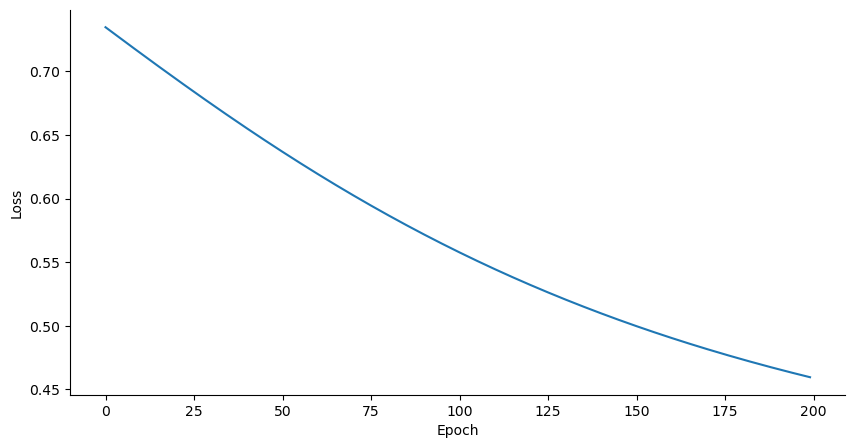

In [151]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(n_train), y=loss_history, ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
sns.despine()
plt.show()


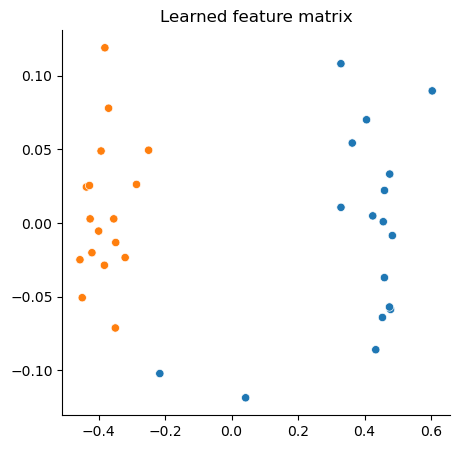

In [155]:
xy = model(X)

fig, ax = plt.subplots(figsize=(5, 5))

xy = PCA(n_components=2).fit_transform(xy.detach().numpy())

sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue = labels,  ax=ax, legend = False)
ax.set_title("Learned feature matrix")
sns.despine()
plt.show()

### Exercise 3 🏋️:

1. Build a two-layer GCN and train it to predict the membership of the karate club.
2. Compare the performance of the two-layer GCN with the one-layer GCN.